In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
!unzip opensnp.zip

In [15]:
%%capture captured
# compute principal components
!plink --bfile openSNP --geno 0.05 --make-bed --out qc/openSNP.pca.step1
!plink --bfile qc/openSNP.pca.step1 --chr 1-22 --indep-pairwise 1000 50 0.05 --make-bed --out qc/openSNP.pca.step2
!plink --bfile qc/openSNP.pca.step1 --extract qc/openSNP.pca.step2.prune.in --make-bed --out qc/openSNP.pca.step3
!plink --bfile qc/openSNP.pca.step3 --make-set qc/high-ld.txt --write-set --out qc/openSNP.pca.step4
!plink --bfile qc/openSNP.pca.step3 --exclude qc/openSNP.pca.step4.set --make-bed --out qc/openSNP.pca.step5

!./flashpca_x86-64 --bfile qc/openSNP.pca.step5 --outload qc/openSNP.pca.loadings.txt --outmeansd qc/openSNP.pca.meansd.txt --suffix _openSNP.csv

!mv eigenvalues_openSNP.csv qc/
!mv eigenvectors_openSNP.csv qc/
!mv pve_openSNP.csv qc/
!mv pcs_openSNP.csv qc/

In [2]:
!wc -l qc/openSNP.pca.step*.bim

  74023 qc/openSNP.pca.step1.bim
  73049 qc/openSNP.pca.step2.bim
  26373 qc/openSNP.pca.step3.bim
  26167 qc/openSNP.pca.step5.bim
 199612 total


In [61]:
%%capture
# find related individuls, computed IBD1 vs IBD2
#!plink --bfile qc/openSNP.pca.step5 --genome --min 0.05 --out qc/openSNP.kinship 
!./king -b qc/openSNP.pca.step5.bed --related --ibs --build --degree 3 --prefix qc/openSNP.pca.step5 > qc/openSNP.pca.step5.king.log
!./king -b qc/openSNP.pca.step5.bed --unrelated --degree 2 --prefix qc/openSNP.pca.step5.

In [50]:
# keep only one in each duplicate cluster
import itertools
import networkx as nx
df_king = pd.read_csv('qc/openSNP.pca.step5.kin0', delim_whitespace=True)
dups = df_king[df_king['InfType']=='Dup/MZ'][['FID1', 'FID2']]
graph = nx.from_pandas_edgelist(dups, 'FID1', 'FID2')
exclude_fids = list(sorted(itertools.chain.from_iterable([list(c)[1:] for c in nx.connected_components(graph)])))
pd.DataFrame({'FID':exclude_fids, 'IID':exclude_fids}).drop_duplicates().to_csv('qc/duplicates.iid', header=None, sep='\t', index=False)

In [51]:
!wc -l qc/duplicates.iid

413 qc/duplicates.iid


In [110]:
%%capture
# remove duplicates (step6) and remove all related individuals (step7)
!plink --bfile qc/openSNP.pca.step5 --remove qc/duplicates.iid --make-bed --out qc/openSNP.pca.step6
!./king -b qc/openSNP.pca.step6.bed --related --ibs --build --degree 3 --prefix qc/openSNP.pca.step6 > qc/openSNP.pca.step6.king.log

!plink --bfile qc/openSNP.pca.step5 --keep qc/openSNP.pca.step5.unrelated.txt --make-bed --out qc/openSNP.pca.step7
!./king -b qc/openSNP.pca.step7.bed --related --ibs --build --degree 3 --prefix qc/openSNP.pca.step7 > qc/openSNP.pca.step7.king.log

Text(0.5, 1.0, 'exclude all related individuals')

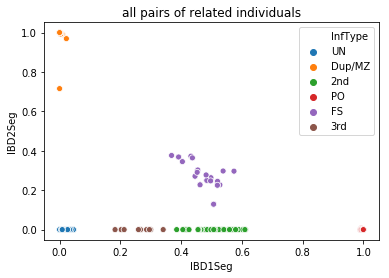

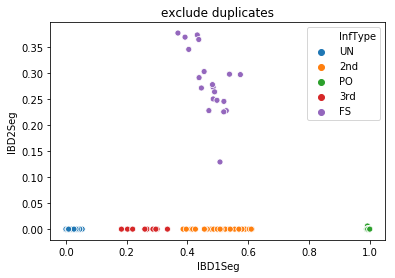

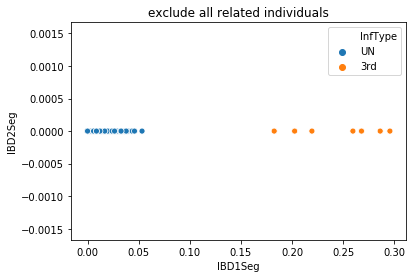

In [112]:
import seaborn as sns

df_king = pd.read_csv('qc/openSNP.pca.step5.kin0', delim_whitespace=True)
plt.figure();
sns.scatterplot(data=df_king, x='IBD1Seg', y='IBD2Seg', hue='InfType');
plt.title('all pairs of related individuals')

df_king = pd.read_csv('qc/openSNP.pca.step6.kin0', delim_whitespace=True)
plt.figure();
sns.scatterplot(data=df_king, x='IBD1Seg', y='IBD2Seg', hue='InfType');
plt.title('exclude duplicates')

df_king = pd.read_csv('qc/openSNP.pca.step7.kin0', delim_whitespace=True)
plt.figure();
sns.scatterplot(data=df_king, x='IBD1Seg', y='IBD2Seg', hue='InfType');
plt.title('exclude all related individuals')

remove 62 outliers


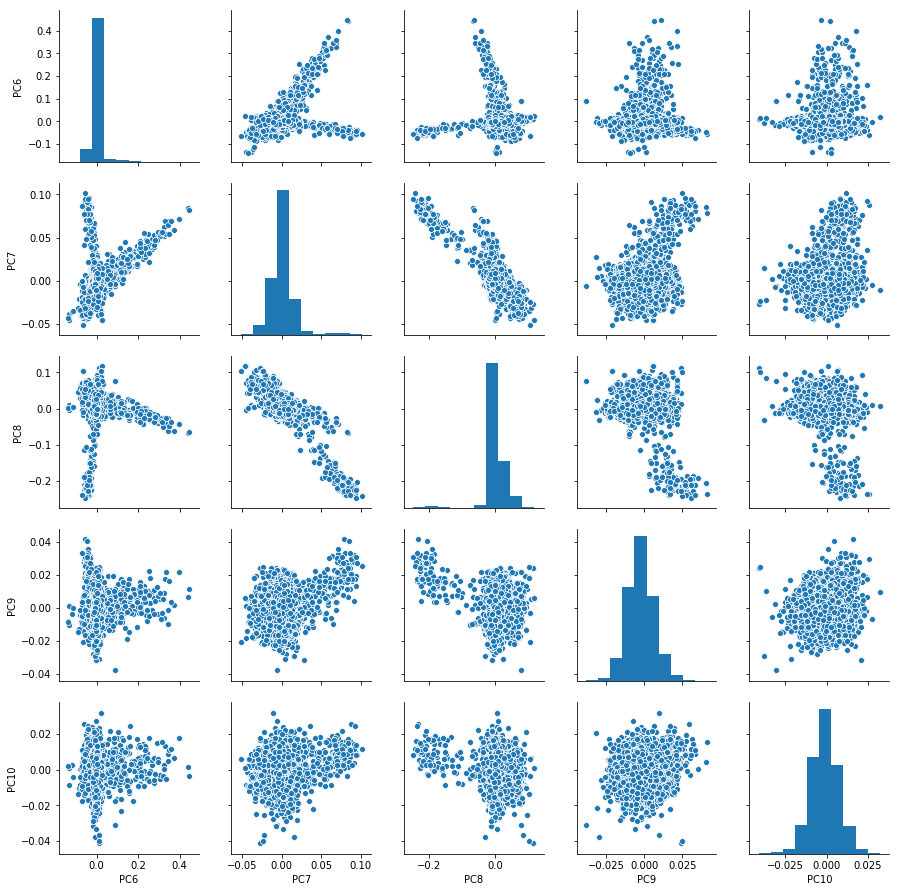

In [3]:
# identify pca outliers (but keep all ancestries);

import seaborn as sns
df_pcs=pd.read_csv('qc/pcs_openSNP.csv',sep='\t')

outliers = df_pcs['PC1'].isnull()
outliers = outliers  | (df_pcs['PC3'] > 0.5) 
outliers = outliers | (df_pcs['PC5'] < -0.5) 
outliers = outliers | (df_pcs['PC5'] > 0.05)
outliers = outliers | (df_pcs['PC7'] < -0.07) 
outliers = outliers | (df_pcs['PC9'] > 0.05) 

print(f'remove {np.sum(outliers)} outliers')
df_pcs[outliers][['FID', 'IID']].to_csv('qc/pca_outliers.iid', sep='\t', index=False, header=None)
df_pcs = df_pcs[~outliers]

sns.pairplot(df_pcs[[ 'PC1', 'PC2', 'PC3', 'PC4', 'PC5' ]])
sns.pairplot(df_pcs[[ 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']])

In [47]:
!wc -l qc/pca_outliers.iid

62 qc/pca_outliers.iid


In [4]:
# prepare subject lists for 5 clusters 
# (different genotyping platrofms - https://www.csbj.org/article/S2001-0370(21)00278-6/fulltext)
genomeslist = pd.read_csv('opensnp_genomeslist.tsv', sep='\t')
genomeslist['findex']=genomeslist['findex'].astype(int)
genomeslist['cluster']
print(genomeslist['cluster'].unique())
for c in genomeslist['cluster'].unique():
    IIDs = genomeslist[genomeslist['cluster']==c][['findex', 'findex']]
    IIDs.to_csv(f'qc/{c}.iid', sep='\t', index=False, header=None)

['c1' 'c3' 'c4' 'c5' 'v5']


In [47]:
%%capture captured
# use relaxed genotype misingness (0.5) for sex check, to avoid excluding all chrX SNPs in cluster c3
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do plink --bfile openSNP --keep qc/$BATCH.iid --geno 0.5 --impute-sex --make-bed --out qc/openSNP.$BATCH.sexcheck; done
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do awk '$5=="PROBLEM" {print $1 "\t" $2 }' qc/openSNP.$BATCH.sexcheck.sexcheck > qc/openSNP.$BATCH.missing_sex.iid; done

In [49]:
# number of ambiguous sex subjects
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do wc -l qc/openSNP.$BATCH.missing_sex.iid; done

13 qc/openSNP.c1.missing_sex.iid
8 qc/openSNP.c4.missing_sex.iid
211 qc/openSNP.c3.missing_sex.iid
10 qc/openSNP.c5.missing_sex.iid
23 qc/openSNP.v5.missing_sex.iid


In [114]:
%%capture captured
# split into 5 batches, then in each batch
# - remove PCA outliers
# - remove subjects with ambiguous sex
# - remove duplicated individuals
# - variant QC (--geno 0.1 --hwe 1e-6 --mac 1)
#   => .step1
# - sample QC (--mind 0.1, exclude HET outliers beyond +- 5 SD)
#   => .step2
#
# self-declared sex is ignored due to high misingness;
# no filtering is done on MAF due to broad range of ancestry data

!cat qc/pca_outliers.iid qc/openSNP.*.missing_sex.iid qc/duplicates.iid | sort | uniq > qc/remove.iid
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do plink --bfile openSNP --keep qc/$BATCH.iid --remove qc/remove.iid --geno 0.1 --hwe 1e-6 --mac 1 --make-bed --out qc/openSNP.$BATCH.step1; done

In [115]:
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do wc -l qc/openSNP.$BATCH.step1.bim; done
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do wc -l qc/openSNP.$BATCH.step1.fam; done

532089 qc/openSNP.c1.step1.bim
843097 qc/openSNP.c4.step1.bim
648293 qc/openSNP.c3.step1.bim
467920 qc/openSNP.c5.step1.bim
554985 qc/openSNP.v5.step1.bim
1852 qc/openSNP.c1.step1.fam
1108 qc/openSNP.c4.step1.fam
467 qc/openSNP.c3.step1.fam
462 qc/openSNP.c5.step1.fam
853 qc/openSNP.v5.step1.fam


In [116]:
%%capture captured
!for BATCH in 'c1' 'c3' 'c4' 'c5' 'v5'; do plink --bfile qc/openSNP.$BATCH.step1 --chr 1-22 --indep-pairwise 1000 50 0.05 --make-bed --out qc/openSNP.$BATCH.het; done
!for BATCH in 'c1' 'c3' 'c4' 'c5' 'v5'; do plink --bfile qc/openSNP.$BATCH.step1 --extract qc/openSNP.$BATCH.het.prune.in --het --out qc/openSNP.$BATCH; done

batch:  c1 , mean:  0.00696479824316463 , se:  0.009823304765250472 ; subj. excluded:  133
batch:  c3 , mean:  0.00614054168591224 , se:  0.009697145754001121 ; subj. excluded:  34
batch:  c4 , mean:  0.008282944633683207 , se:  0.009698893857916687 ; subj. excluded:  60
batch:  c5 , mean:  0.00405678253427896 , se:  0.008217731880107118 ; subj. excluded:  39
batch:  v5 , mean:  0.004916286878980891 , se:  0.010542750686891934 ; subj. excluded:  68


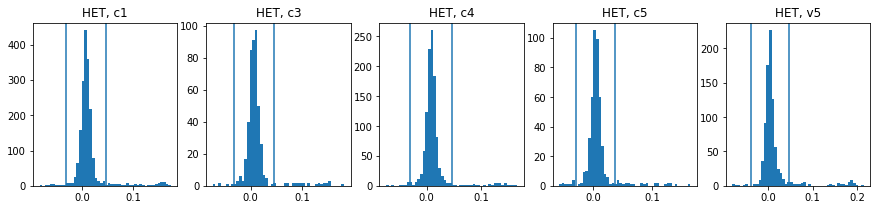

In [22]:
# iteratively exclude het outliers (5 standard deviations away from the mean)
plt.figure(figsize=(15,3))
se_factor = 4
for i, batch in enumerate(['c1', 'c3', 'c4', 'c5', 'v5']):
    df_het = pd.read_csv(f'qc/openSNP.{batch}.het', delim_whitespace=True)
    plt.subplot(1,5,i+1)
    done = False
    pass_het_check = ~df_het['F'].isnull(); 
    plt.hist(df_het['F'].values, bins=50)
    count = np.sum(pass_het_check)
    
    for iter in range(10):
        m=np.mean(df_het[pass_het_check]['F'].values)
        s=np.std(df_het[pass_het_check]['F'].values)
        pass_het_check = pass_het_check & (df_het['F'] >= (m - se_factor*s)) & (df_het['F'] <= (m + se_factor*s))
        if count == pass_het_check.sum():
            break
        count = pass_het_check.sum()
        plt.title(f'HET, {batch}')
    print('batch: ', batch, ', mean: ', m, ', se: ', s, '; subj. excluded: ', len(pass_het_check) - pass_het_check.sum()) 

    plt.axvline(m-se_factor*s)
    plt.axvline(m+se_factor*s)
    df_het[~pass_het_check][['FID', 'IID']].to_csv(f'qc/openSNP.{batch}.het.iid', sep='\t', index=False)

In [52]:
%%capture captured
for BATCH in ['c1', 'c3', 'c4', 'c5', 'v5']:
    df_bim = pd.read_csv(f'qc/openSNP.{BATCH}.step1.bim', sep='\t', header=None, names=['CHR', 'SNP', 'GP', 'BP',  'A1', 'A2'])
    for CHR in range(1, 23):
        max_bp = df_bim[df_bim['CHR'] == CHR]['BP'].max()
        chunk_size = 20e6  # michigan imputation server imputes in chunks of 20 MB
                           # it excludes a chunk if at least one subject had a missingness > 50% in that chunk
        for chunk_idx, to in enumerate(np.arange(chunk_size, max_bp+chunk_size, chunk_size)):
            os.system(f'plink --bfile qc/openSNP.{BATCH}.step1 --chr {CHR} --from-bp {to-chunk_size} --to-bp {to} --mind 0.5 --make-bed --out qc/openSNP.{BATCH}.step1.chr{CHR}.chunk{chunk_idx+1} >/dev/null 2>&1')

!cat qc/openSNP.*.step1.chr*.chunk*.irem | sort | uniq > qc/high_missing_in_chunks2.iid
!rm qc/openSNP.*.step1.chr*.chunk*

In [53]:
!wc -l qc/high_missing_in_chunks2.iid

152 qc/high_missing_in_chunks2.iid


In [54]:
%%capture captured
!cat qc/pca_outliers.iid qc/openSNP.*.missing_sex.iid qc/duplicates.iid qc/openSNP.*.het.iid  qc/high_missing_in_chunks2.iid | sort | uniq > qc/remove.iid
!for BATCH in 'c1' 'c3' 'c4' 'c5' 'v5'; do plink --bfile qc/openSNP.$BATCH.step1 --mind 0.1 --remove qc/remove.iid --make-bed --out qc/openSNP.$BATCH.step2; done

In [55]:
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do wc -l qc/openSNP.$BATCH.step2.fam; done | grep -v total

1717 qc/openSNP.c1.step2.fam
942 qc/openSNP.c4.step2.fam
430 qc/openSNP.c3.step2.fam
417 qc/openSNP.c5.step2.fam
740 qc/openSNP.v5.step2.fam


In [32]:
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do wc -l qc/openSNP.$BATCH.step2.bim; done | grep -v total

532089 qc/openSNP.c1.step2.bim
843097 qc/openSNP.c4.step2.bim
648293 qc/openSNP.c3.step2.bim
467920 qc/openSNP.c5.step2.bim
554985 qc/openSNP.v5.step2.bim


In [57]:
%%capture captured
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do ./PRE_PHASING_QC.sh qc/openSNP.$BATCH.step2 qc/openSNP.$BATCH.step3; done

In [59]:
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do wc -l qc/openSNP.$BATCH.step3.bim; done | grep -v total

512214 qc/openSNP.c1.step3.bim
819057 qc/openSNP.c4.step3.bim
632900 qc/openSNP.c3.step3.bim
446921 qc/openSNP.c5.step3.bim
536405 qc/openSNP.v5.step3.bim


In [61]:
!for BATCH in 'c1' 'c4' 'c3' 'c5' 'v5'; do wc -l qc/openSNP.$BATCH.step3.fam qc/$BATCH.iid; done | grep -v total

 1717 qc/openSNP.c1.step3.fam
 2006 qc/c1.iid
  942 qc/openSNP.c4.step3.fam
 1190 qc/c4.iid
  430 qc/openSNP.c3.step3.fam
  752 qc/c3.iid
  417 qc/openSNP.c5.step3.fam
  522 qc/c5.iid
  740 qc/openSNP.v5.step3.fam
  923 qc/v5.iid


In [62]:
%%capture captured
!for BATCH in 'c1' 'c3' 'c4' 'c5' 'v5'; do cp qc/openSNP.$BATCH.step3.bim qc/openSNP.$BATCH.qc.bim; done
!for BATCH in 'c1' 'c3' 'c4' 'c5' 'v5'; do cp qc/openSNP.$BATCH.step3.bed qc/openSNP.$BATCH.qc.bed; done
!for BATCH in 'c1' 'c3' 'c4' 'c5' 'v5'; do cp qc/openSNP.$BATCH.step3.fam qc/openSNP.$BATCH.qc.fam; done
!for BATCH in 'c1' 'c3' 'c4' 'c5' 'v5'; do plink --bfile qc/openSNP.$BATCH.qc --freq --out qc/openSNP.$BATCH.qc; done

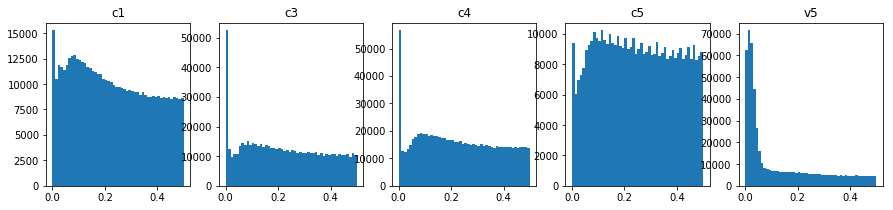

In [63]:
plt.figure(figsize=(15,3))
for i, batch in enumerate(['c1', 'c3', 'c4', 'c5', 'v5']):
    plt.subplot(1,5,i+1)
    df_maf = pd.read_csv(f'qc/openSNP.{batch}.qc.frq',delim_whitespace=True)
    plt.hist(df_maf['MAF'].values, bins=50);
    plt.title(batch)